# Bias analysis

## Loading the data

In [1]:
# Importing libraries

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import re

from tqdm import tqdm

import warnings

warnings.filterwarnings('ignore')

In [2]:
# Importing our own modules

import sys

sys.path.insert(0, '/Users/manu/Desktop/ML_Projects/DataScientest/DoctorPy')

from utils.preprocessing import resize_img, img_zoom, thresh_inf, edge_brightness, adjust_brightness_func, lda_test
from utils.unet_pp import final_pp, build_model

In [3]:
covid_path = '../data/COVID-19/'
covid_files = [covid_path + file for file in os.listdir(covid_path) if file[-3:] == 'png']

normal_path = '../data/NORMAL/'
normal_files = [normal_path + file for file in os.listdir(normal_path) if file[-3:] == 'png']

vp_path = '../data/Viral Pneumonia/'
vp_files = [vp_path + file for file in os.listdir(vp_path) if file[-3:] == 'png']

# Each variable contains the path to the associated images

In [4]:
df = pd.read_csv('../data/eda_df.csv', index_col=0)
df['version'] = 'old'
df = df.drop('entropy', axis=1)

In [5]:
target = df['label']

## Zooming on the images

In [20]:
# Creating the arrays and filling them in the loop

d_c_zoom = np.zeros((len(covid_files), 256, 256))

for i in range(len(covid_files)):
    d_c_zoom[i] = resize_img(img_zoom(df['path'].iloc[i]))
    
# Same thing for the next classes now
    
d_n_zoom = np.zeros((len(normal_files), 256, 256))

for i in range(len(covid_files), len(covid_files) + len(normal_files)):
    d_n_zoom[i - len(covid_files)] = resize_img(img_zoom(df['path'].iloc[i]))
    
d_vp_zoom = np.zeros((len(vp_files), 256, 256))

for i in range(len(covid_files) + len(normal_files), len(covid_files) + len(normal_files) + len(vp_files)):
    d_vp_zoom[i - (len(covid_files) + len(normal_files))] = resize_img(img_zoom(df['path'].iloc[i]))

In [21]:
images = np.concatenate([d_c_zoom, d_n_zoom, d_vp_zoom], axis=0)

In [22]:
# Creating the dataframe containing the relevant information on the various preprocessings

df_c = pd.DataFrame({'path': covid_files})
df_c['image'] = df_c['path'].apply(lambda x: re.split(r'[\(\)]', x)[1]).astype('int')
df_c = df_c.sort_values('image')
df_c = df_c.reset_index(drop=True)
df_c['label'] = 'COVID-19'
df_c['version'] = 'zoom'


df_n = pd.DataFrame({'path': normal_files})
df_n['image'] = df_n['path'].apply(lambda x: re.split(r'[\(\)]', x)[1]).astype('int')
df_n = df_n.sort_values('image')
df_n = df_n.reset_index(drop=True)
df_n['label'] = 'NORMAL'
df_n['version'] = 'zoom'

df_vp = pd.DataFrame({'path': vp_files})
df_vp['image'] = df_vp['path'].apply(lambda x: re.split(r'[\(\)]', x)[1]).astype('int')
df_vp = df_vp.sort_values('image')
df_vp = df_vp.reset_index(drop=True)
df_vp['label'] = 'Viral Pneumonia'
df_vp['version'] = 'zoom'

df_z = pd.concat([df_c, df_n, df_vp], ignore_index=True)

df_z.head()

,path,image,label,version
0,../data/COVID-19/COVID-19 (1).png,1,COVID-19,zoom
1,../data/COVID-19/COVID-19 (2).png,2,COVID-19,zoom
2,../data/COVID-19/COVID-19 (3).png,3,COVID-19,zoom
3,../data/COVID-19/COVID-19 (4).png,4,COVID-19,zoom
4,../data/COVID-19/COVID-19 (5).png,5,COVID-19,zoom


In [23]:
df_z['mean'] = [img.mean() for img in images]
df_z['std'] = [img.std() for img in images]
df_z['thresh_inf_50'] = [thresh_inf(img) for img in images]
df_z['edge_brightness'] = [edge_brightness(img)[0] for img in images]

In [24]:
df = pd.concat([df, df_z], ignore_index=True)

We will begin by checking the main reasons we decided on a zoom: the threshold and edge intensity features.

### Boxplots

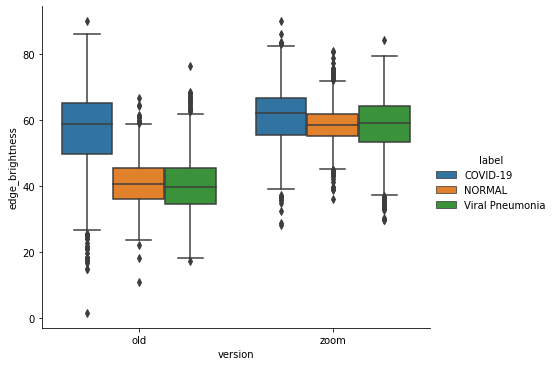

In [25]:
sns.catplot(kind='box', x='version', y='edge_brightness', hue='label', data=df, height=5, aspect=1.2);

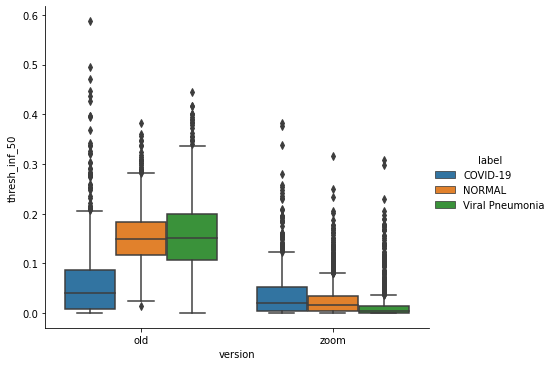

In [26]:
sns.catplot(kind='box', x='version', y='thresh_inf_50', hue='label', data=df, height=5, aspect=1.2);

It does seem that some biases are reduced. We will now check the other boxplots to make sure we're not creating new problems.

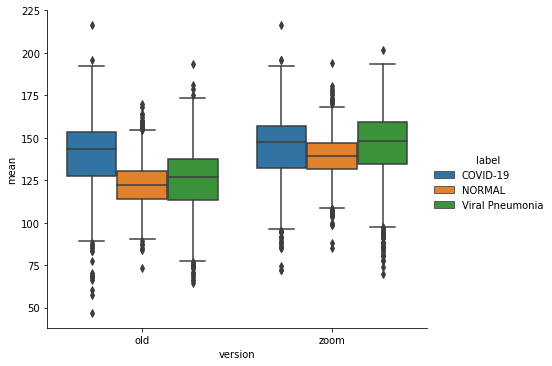

In [27]:
sns.catplot(kind='box', x='version', y='mean', hue='label', data=df, height=5, aspect=1.2);

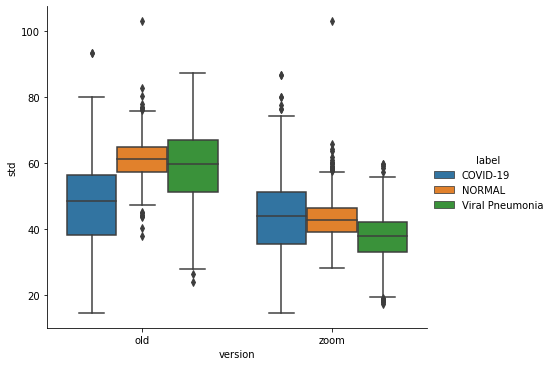

In [28]:
sns.catplot(kind='box', x='version', y='std', hue='label', data=df, height=5, aspect=1.2);

The zoom version of the images seems to solve a lot of portential issues. This will thus be the starting point for all our preprocessings.

### LDA

In [29]:
X_train, X_test, y_train, y_test = train_test_split(images, target,
                                                    test_size=0.2, random_state=42)

Test score: 0.87


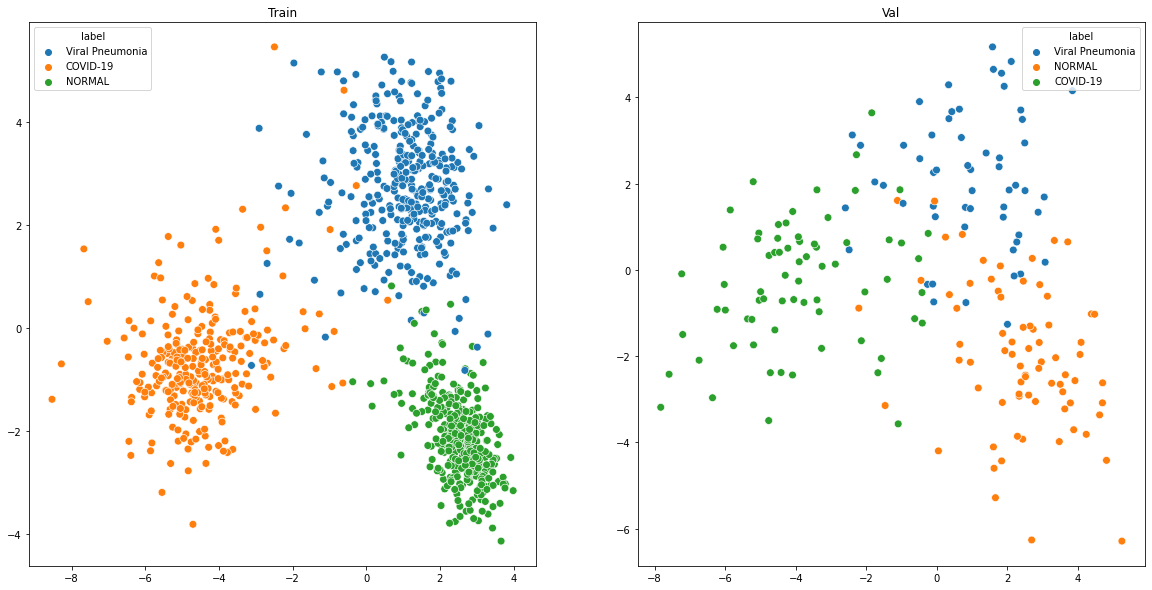

In [30]:
score_test, score_train, fig = lda_test(X_train[:1000].reshape(1000, -1),
                                        X_test[:200].reshape(200, -1),
                                        y_train[:1000],
                                        y_test[:200])

print('Test score:', score_test)

Only by reducing the dimensionality, a non tuned Random Forest classifier is able to distinguish the three classes with an almost 90% accuracy.<br>
This means there are still strong biases.

## Brightness standardization

In [31]:
# Creating the arrays and filling them in the loop

d_c_b = np.zeros((len(covid_files), 256, 256))

for i, img in enumerate(d_c_zoom):
    d_c_b[i] = adjust_brightness_func(img)
    
# Same thing for the next classes now
    
d_n_b = np.zeros((len(normal_files), 256, 256))

for i, img in enumerate(d_n_zoom):
    d_n_b[i] = adjust_brightness_func(img)
    
d_vp_b = np.zeros((len(vp_files), 256, 256))

for i, img in enumerate(d_vp_zoom):
    d_vp_b[i] = adjust_brightness_func(img)

In [32]:
images = np.concatenate([d_c_b, d_n_b, d_vp_b], axis=0)

In [33]:
# Creating the dataframe containing the relevant information on the various preprocessings

df_c = pd.DataFrame({'path': covid_files})
df_c['image'] = df_c['path'].apply(lambda x: re.split(r'[\(\)]', x)[1]).astype('int')
df_c = df_c.sort_values('image')
df_c = df_c.reset_index(drop=True)
df_c['label'] = 'COVID-19'
df_c['version'] = 'brightness'


df_n = pd.DataFrame({'path': normal_files})
df_n['image'] = df_n['path'].apply(lambda x: re.split(r'[\(\)]', x)[1]).astype('int')
df_n = df_n.sort_values('image')
df_n = df_n.reset_index(drop=True)
df_n['label'] = 'NORMAL'
df_n['version'] = 'brightness'

df_vp = pd.DataFrame({'path': vp_files})
df_vp['image'] = df_vp['path'].apply(lambda x: re.split(r'[\(\)]', x)[1]).astype('int')
df_vp = df_vp.sort_values('image')
df_vp = df_vp.reset_index(drop=True)
df_vp['label'] = 'Viral Pneumonia'
df_vp['version'] = 'brightness'

df_b = pd.concat([df_c, df_n, df_vp], ignore_index=True)

df_b.head()

,path,image,label,version
0,../data/COVID-19/COVID-19 (1).png,1,COVID-19,brightness
1,../data/COVID-19/COVID-19 (2).png,2,COVID-19,brightness
2,../data/COVID-19/COVID-19 (3).png,3,COVID-19,brightness
3,../data/COVID-19/COVID-19 (4).png,4,COVID-19,brightness
4,../data/COVID-19/COVID-19 (5).png,5,COVID-19,brightness


In [34]:
df_b['mean'] = [img.mean() for img in images]
df_b['std'] = [img.std() for img in images]
df_b['thresh_inf_50'] = [thresh_inf(img) for img in images]
df_b['edge_brightness'] = [edge_brightness(img)[0] for img in images]

In [35]:
df_b.head()

,path,image,label,version,mean,std,thresh_inf_50,edge_brightness
0,../data/COVID-19/COVID-19 (1).png,1,COVID-19,brightness,120.510200,40.498611,0.060242,49.044280
1,../data/COVID-19/COVID-19 (2).png,2,COVID-19,brightness,120.000000,47.190200,0.055283,51.740110
2,../data/COVID-19/COVID-19 (3).png,3,COVID-19,brightness,120.382049,52.065381,0.113861,51.326401
3,../data/COVID-19/COVID-19 (4).png,4,COVID-19,brightness,120.000000,37.469542,0.010483,48.631565
4,../data/COVID-19/COVID-19 (5).png,5,COVID-19,brightness,120.094356,52.487291,0.098557,52.107632


In [36]:
df = pd.concat([df, df_b], ignore_index=True)

Let us now visualize the different boxplots

### Boxplots

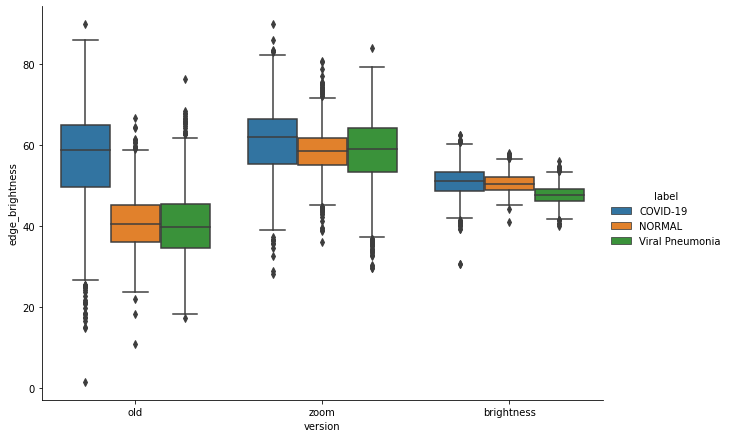

In [37]:
sns.catplot(kind='box', x='version', y='edge_brightness', hue='label', data=df, height=6, aspect=1.4);

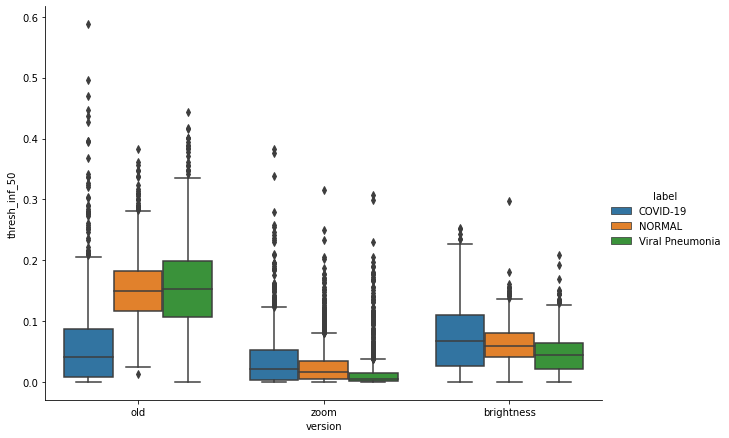

In [38]:
sns.catplot(kind='box', x='version', y='thresh_inf_50', hue='label', data=df, height=6, aspect=1.4);

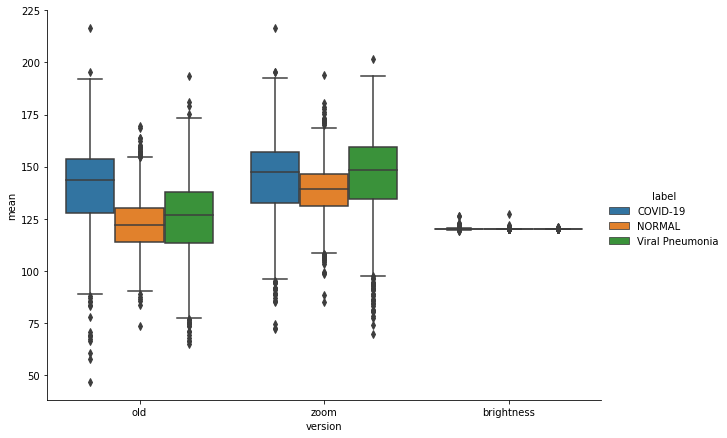

In [39]:
sns.catplot(kind='box', x='version', y='mean', hue='label', data=df, height=6, aspect=1.4);

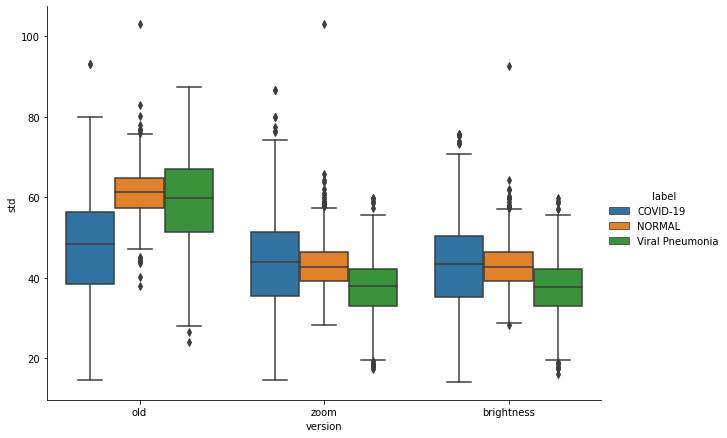

In [40]:
sns.catplot(kind='box', x='version', y='std', hue='label', data=df, height=6, aspect=1.4);

This preprocessing is interesting. It normalizes the mean, as expected, without affecting the other features too much, apart from the edge intensity.

### LDA

In [41]:
X_train, X_test, y_train, y_test = train_test_split(images, target,
                                                    test_size=0.2, random_state=42)

Test score: 0.875


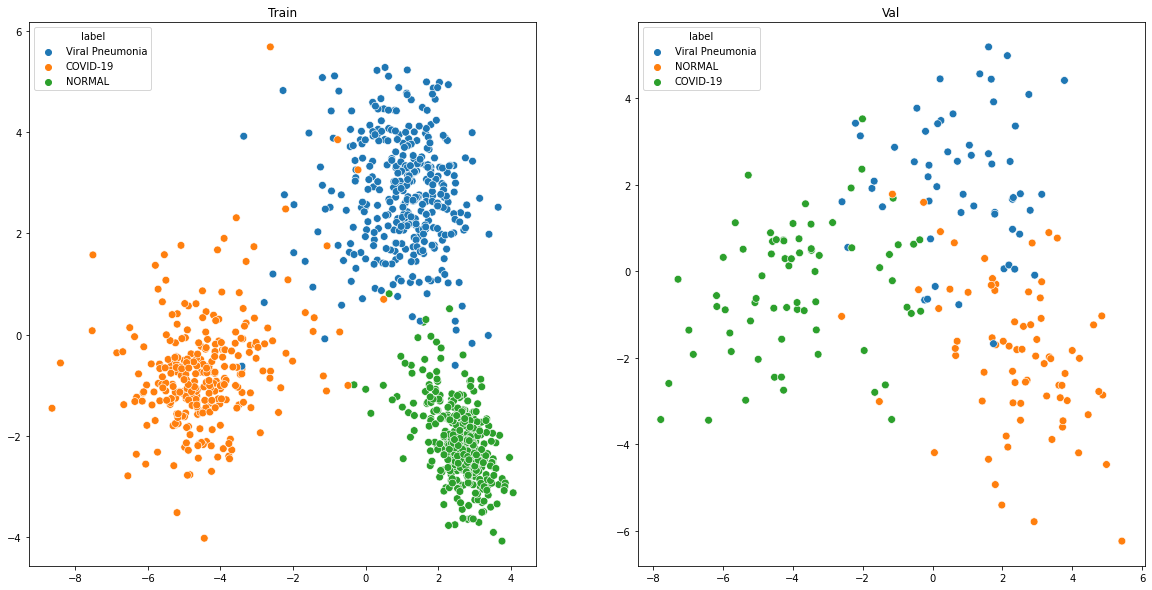

In [42]:
score_test, score_train, fig = lda_test(X_train[:1000].reshape(1000, -1),
                                        X_test[:200].reshape(200, -1),
                                        y_train[:1000],
                                        y_test[:200])

print('Test score:', score_test)

Once again, the score is too high.

## U-Net preprocessing

Nous allons maintenant tester un preprocessing U-Net, permettant de ne garder que les poumons sur les images.

In [7]:
model = build_model(path='../models/Unet_best.h5')

In [30]:
# Creating the arrays and filling them in the loop

d_c_u = np.zeros((len(covid_files), 256, 256))

for i in tqdm(range(len(covid_files))):
    d_c_u[i] = final_pp(df['path'].iloc[i], model=model)
    
# Same thing for the next classes now
    
d_n_u = np.zeros((len(normal_files), 256, 256))

for i in tqdm(range(len(covid_files), len(covid_files) + len(normal_files))):
    d_n_u[i - len(covid_files)] = final_pp(df['path'].iloc[i], model=model)
    
d_vp_u = np.zeros((len(vp_files), 256, 256))

for i in tqdm(range(len(covid_files) + len(normal_files), len(covid_files) + len(normal_files) + len(vp_files))):
    d_vp_u[i - (len(covid_files) + len(normal_files))] = final_pp(df['path'].iloc[i], model=model)

  0%|                                                  | 0/1143 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-07-15 10:40:51.075501: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-07-15 10:40:51.077038: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz
100%|███████████████████████████████████████| 1345/1345 [12:06<00:00,  1.85it/s]


In [40]:
# np.save('../data/c_unet.npy', d_c_u)
# np.save('../data/n_unet.npy', d_n_u)
# np.save('../data/vp_unet.npy', d_vp_u)

In [44]:
# d_c_u = np.load('../data/c_unet.npy')
# d_n_u = np.load('../data/n_unet.npy')
# d_vp_u = np.load('../data/vp_unet.npy')

In [45]:
images = np.concatenate([d_c_u, d_n_u, d_vp_u], axis=0)

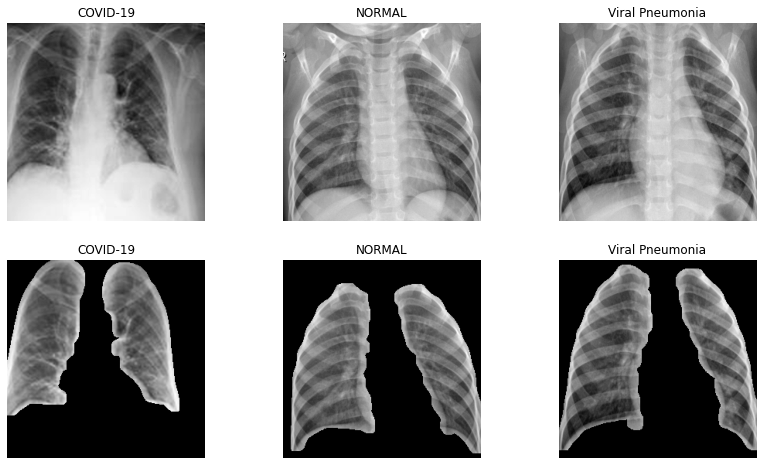

In [11]:
plt.figure(figsize=(14,8))

i = np.random.randint(0, len(covid_files))
j = np.random.randint(len(covid_files), len(covid_files) + len(normal_files))
k = np.random.randint(len(covid_files) + len(normal_files), len(covid_files) + len(normal_files) + len(vp_files))

plt.subplot(231)
plt.imshow(img_zoom(df['path'].iloc[i]), cmap='gray')
plt.axis('off')
plt.title('COVID-19')


plt.subplot(232)
plt.imshow(img_zoom(df['path'].iloc[j]), cmap='gray')
plt.axis('off')
plt.title('NORMAL')


plt.subplot(233)
plt.imshow(img_zoom(df['path'].iloc[k]), cmap='gray')
plt.axis('off')
plt.title('Viral Pneumonia')


plt.subplot(234)
plt.imshow(final_pp(df['path'].iloc[i], model=model), cmap='gray')
plt.axis('off')
plt.title('COVID-19')


plt.subplot(235)
plt.imshow(final_pp(df['path'].iloc[j], model=model), cmap='gray')
plt.axis('off')
plt.title('NORMAL')


plt.subplot(236)
plt.imshow(final_pp(df['path'].iloc[k], model=model), cmap='gray')
plt.axis('off')
plt.title('Viral Pneumonia');


In [46]:
X_train, X_test, y_train, y_test = train_test_split(images, target,
                                                    test_size=0.2, random_state=42)

Test score: 0.845


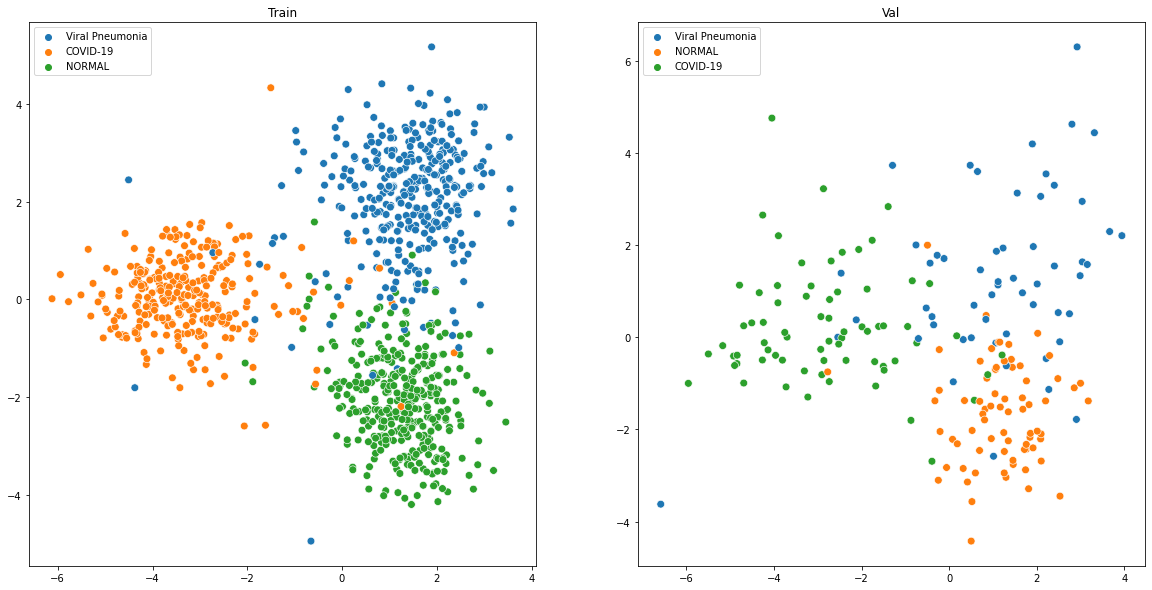

In [36]:
score_test, score_train, fig = lda_test(X_train[:1000].reshape(1000, -1),
                                        X_test[:200].reshape(200, -1),
                                        y_train.values[:1000],
                                        y_test.values[:200])

print('Test score:', score_test)

Since the results all disappoint, we will stick with the brightness adjustment preprocessing, since we have decent improvement over the initial images without losing any information.